# Códigos Examen de Algoritmos Bioinspirados 
# BLOQUE 1
Chiara Bombardieri Balanzá - A01659462

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

Núcleo del algoritmo

In [4]:

# Función objetivo OneMax.
def onemax_fitness(pop):
    return pop.sum(axis=1)

# Inicialización uniforme independiente
def init_population(pop_size: int, genome_len: int, rng: np.random.Generator):
    return rng.integers(0, 2, size=(pop_size, genome_len), dtype=np.uint8)

# Selección por torneo de tamaño k (maximización)
def tournament_selection(fit: np.ndarray, k: int, rng: np.random.Generator):
    """
    Devuelve el índice del individuo seleccionado.
    """
    idxs = rng.integers(0, len(fit), size=k)
    return int(idxs[np.argmax(fit[idxs])])

# Cruce de un punto
def crossover_one_point(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator):
    """
    El punto se elige en {1, ..., L-1}.
    """
    L = p1.shape[0]
    cut = int(rng.integers(1, L))
    c1 = np.empty_like(p1)
    c2 = np.empty_like(p1)
    c1[:cut], c1[cut:] = p1[:cut], p2[cut:]
    c2[:cut], c2[cut:] = p2[:cut], p1[cut:]
    return c1, c2


def crossover_uniform(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator, p: float = 0.5):
    """
    Cruce uniforme con máscara Bernoulli(p).
    """
    mask = rng.random(p1.shape[0]) < p
    c1 = np.where(mask, p1, p2).astype(np.uint8)
    c2 = np.where(mask, p2, p1).astype(np.uint8)
    return c1, c2

# Mutación 
def mutate_bitflip(ind: np.ndarray, pm: float, rng: np.random.Generator):
    """
    Mutación bit-flip independiente con probabilidad pm.
    """
    flips = rng.random(ind.shape[0]) < pm
    ind[flips] ^= 1

# Diversidad de la población 
def population_diversity(pop: np.ndarray):
    p = pop.mean(axis=0)
    return float(np.mean(2 * p * (1 - p)))

# Creación de un data class inmutable 
@dataclass(frozen=True)

# Parámetros del AG
class GAConfig:
    name: str
    pop_size: int
    genome_len: int = 100
    pm: float = 0.01          # prob. de mutación por bit
    pc: float = 0.9           # prob. de cruce por pareja
    tournament_k: int = 3
    elitism: int = 2
    crossover: str = "one_point"  
    max_gens: int = 200
    seed: int = 12345


def run_ga(cfg: GAConfig, rng: np.random.Generator):
    """
    Ejecuta un AG para OneMax con parámetros cfg.
    Devuelve historia del mejor y promedio por generación, diversidad y métricas de convergencia.
    """
    L = cfg.genome_len
    pop = init_population(cfg.pop_size, L, rng)

    best_hist, mean_hist, div_hist = [], [], []
    reached_opt, gen_opt = False, np.nan

    for gen in range(cfg.max_gens):
        fit = onemax_fitness(pop)
        order = np.argsort(fit)[::-1]
        pop, fit = pop[order], fit[order]

        best_hist.append(int(fit[0]))
        mean_hist.append(float(fit.mean()))
        div_hist.append(population_diversity(pop))

        if (not reached_opt) and (fit[0] == L):
            reached_opt, gen_opt = True, float(gen)

        elites = pop[:cfg.elitism].copy()
        new_pop = [elites[i] for i in range(cfg.elitism)]

        while len(new_pop) < cfg.pop_size:
            i1 = tournament_selection(fit, cfg.tournament_k, rng)
            i2 = tournament_selection(fit, cfg.tournament_k, rng)
            p1, p2 = pop[i1], pop[i2]

            if rng.random() < cfg.pc:
                if cfg.crossover == "one_point":
                    c1, c2 = crossover_one_point(p1, p2, rng)
                elif cfg.crossover == "uniform":
                    c1, c2 = crossover_uniform(p1, p2, rng)
                else:
                    raise ValueError("Crossover no reconocido.")
            else:
                c1, c2 = p1.copy(), p2.copy()

            mutate_bitflip(c1, cfg.pm, rng)
            mutate_bitflip(c2, cfg.pm, rng)

            new_pop.append(c1)
            if len(new_pop) < cfg.pop_size:
                new_pop.append(c2)

        pop = np.array(new_pop, dtype=np.uint8)

    return {
        "best_hist": np.array(best_hist, dtype=np.int32),
        "mean_hist": np.array(mean_hist, dtype=float),
        "div_hist": np.array(div_hist, dtype=float),
        "reached_opt": reached_opt,
        "gen_opt": gen_opt,
        "final_best": int(best_hist[-1]),
    }


# Función de ejcución de replicas
def run_replicas(cfg: GAConfig, runs: int = 30, base_seed: int = 20251015):
    """
    Ejecuta múltiples réplicas independientes y agrega resultados.
    """
    best_stack, mean_stack, div_stack = [], [], []
    success, gens_to_opt, finals = [], [], []

    for r in range(runs):
        rng = np.random.default_rng(seed=base_seed + r * 17 + hash(cfg.name) % 1_000_000)
        out = run_ga(cfg, rng)
        best_stack.append(out["best_hist"])
        mean_stack.append(out["mean_hist"])
        div_stack.append(out["div_hist"])
        success.append(bool(out["reached_opt"]))
        gens_to_opt.append(out["gen_opt"])
        finals.append(out["final_best"])

    return {
        "cfg": cfg,
        "best_stack": np.vstack(best_stack),
        "mean_stack": np.vstack(mean_stack),
        "div_stack": np.vstack(div_stack),
        "success_rate": float(np.mean(success)),
        "gens_to_opt": np.array(gens_to_opt, dtype=float),
        "final_best": np.array(finals, dtype=int),
    }


Definición de configuraciones

In [ ]:
cfg1 = GAConfig(
    name="Config 1",
    pop_size=50,
    crossover="one_point",
    pm=0.01,
    genome_len=100,
    pc=0.9,
    max_gens=200,
    elitism=2,
    tournament_k=3,
    seed=123
)

cfg2 = GAConfig(
    name="Config 2",
    pop_size=100,
    crossover="uniform",
    pm=0.1,
    genome_len=100,
    pc=0.9,
    max_gens=200,
    elitism=2,
    tournament_k=3,
    seed=456
)

Ejecución y visualización

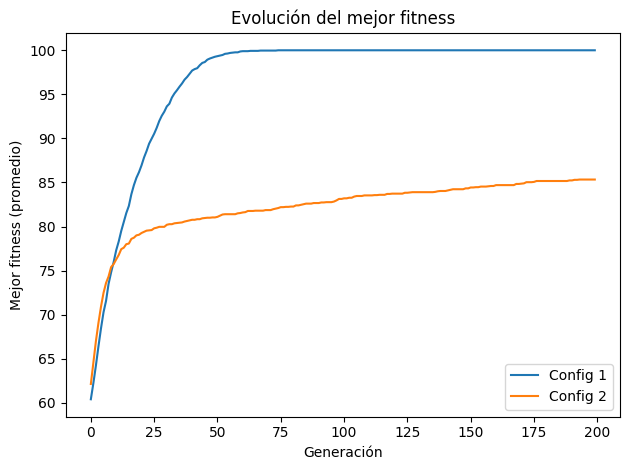

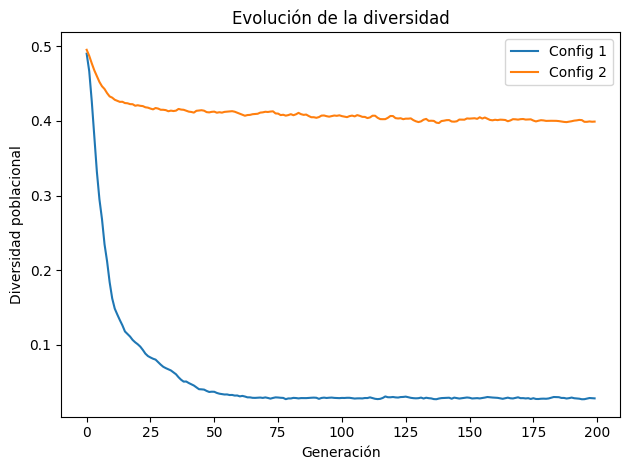

Resumen comparativo
- Config 1: éxito=100.0%, mediana gens óptimo=51.0, fitness final (mediana)=100
- Config 2: éxito=0.0%, mediana gens óptimo=nan, fitness final (mediana)=85


In [8]:
res1 = run_replicas(cfg1, runs=30)
res2 = run_replicas(cfg2, runs=30)

# Gráfico de evelución del mejro fitness
plt.figure()
plt.plot(res1["best_stack"].mean(axis=0), label=cfg1.name)
plt.plot(res2["best_stack"].mean(axis=0), label=cfg2.name)
plt.xlabel("Generación")
plt.ylabel("Mejor fitness (promedio)")
plt.title("Evolución del mejor fitness")
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico de evolución de la diversidad 
plt.figure()
plt.plot(res1["div_stack"].mean(axis=0), label=cfg1.name)
plt.plot(res2["div_stack"].mean(axis=0), label=cfg2.name)
plt.xlabel("Generación")
plt.ylabel("Diversidad poblacional")
plt.title("Evolución de la diversidad")
plt.legend()
plt.tight_layout()
plt.show()


# Resumen de resultados
print("Resumen comparativo")
for res in (res1, res2):
    cfg = res["cfg"]
    sr = res["success_rate"] * 100
    g = res["gens_to_opt"]
    g_ok = g[~np.isnan(g)]
    med_g = float(np.median(g_ok)) if len(g_ok) else np.nan
    med_final = int(np.median(res["final_best"]))
    print(f"- {cfg.name}: éxito={sr:.1f}%, mediana gens óptimo={med_g}, fitness final (mediana)={med_final}")